In [1]:
# !apt install libeigen3-dev

In [1]:
%%writefile svd.cpp
#include <iostream>
#include <fstream>
#include <Eigen/Dense>
#include <random>
#include <chrono>

using namespace std;
using namespace Eigen;

int main() {
    // Set random seed for reproducibility
    srand(time(0));

    // Define dimensions of the matrix
    int n = 100; // Number of rows
    int m = 100; // Number of columns

    // Generate random matrix X with values from a standard normal distribution
    MatrixXd X(n, m);
    random_device rd;
    mt19937 gen(rd());
    normal_distribution<double> dist(0.0, 1.0);

    auto start_time = chrono::high_resolution_clock::now(); // Start timing

    for (int i = 0; i < n; ++i) {
        for (int j = 0; j < m; ++j) {
            X(i, j) = i+j+dist(gen)*0.001;
        }
    }

    // Compute mean across columns
    RowVectorXd X_mean = X.colwise().mean();

    // Subtract mean to center the data
    MatrixXd B = X;
    for (int i = 0; i < n; ++i) {
        B.row(i) -= X_mean;
    }

    // Compute variance of the data
    double var = (B.array().square()).sum() / (n * m);

    // Normalize the data by dividing by the square root of variance
    B /= sqrt(var);

    // Compute covariance matrix
    MatrixXd C = (B.transpose() * B) / (n - 1);

    // Perform eigen decomposition
    SelfAdjointEigenSolver<MatrixXd> eigen_solver(C);
    VectorXd d = eigen_solver.eigenvalues(); // Eigenvalues
    MatrixXd V = eigen_solver.eigenvectors(); // Eigenvectors

    // Project X onto PC space
    MatrixXd T_pca = B * V;

    // Perform Singular Value Decomposition (SVD)
    JacobiSVD<MatrixXd> svd(B, ComputeThinU | ComputeThinV);
    MatrixXd U = svd.matrixU();
    VectorXd S = svd.singularValues();
    MatrixXd Vt = svd.matrixV().transpose();

    // Construct the Sigma matrix
    MatrixXd Sigma(n, m);
    Sigma.setZero();
    for (int i = 0; i < S.size(); ++i) {
        Sigma(i, i) = S(i);
    }

    // Compute T_svd = U * Sigma
    MatrixXd T_svd = U * Sigma;

    auto end_time = chrono::high_resolution_clock::now(); // End timing
    chrono::duration<double> elapsed_seconds = end_time - start_time;

    // Save results to files
    ofstream pca_file("pca_results.txt");
    ofstream svd_file("svd_results.txt");
    ofstream singular_values_file("singular_values.txt");
    ofstream eigenvalues_file("eigenvalues.txt");

    if (pca_file.is_open()) {
        pca_file << "Principal components using PCA T_pca = B * V:\n";
        pca_file << T_pca << endl;
        pca_file.close();
    }

    if (svd_file.is_open()) {
        svd_file << "Principal components using SVD T_svd = U * Sigma:\n";
        svd_file << T_svd << endl;
        svd_file.close();
    }

    if (singular_values_file.is_open()) {
        singular_values_file << "Singular values of B matrix:\n";
        singular_values_file << S << endl;
        singular_values_file.close();
    }

    if (eigenvalues_file.is_open()) {
        eigenvalues_file << "Eigenvalues of C matrix:\n";
        eigenvalues_file << d << endl;
        eigenvalues_file.close();
    }

    // Print execution time
    cout << "Execution time: " << elapsed_seconds.count() << " seconds" << endl;

    return 0;
}

Overwriting svd.cpp


In [2]:
!g++ -I/usr/include/eigen3 svd.cpp -o svd


In [3]:
!./svd

Execution time: 0.324981 seconds


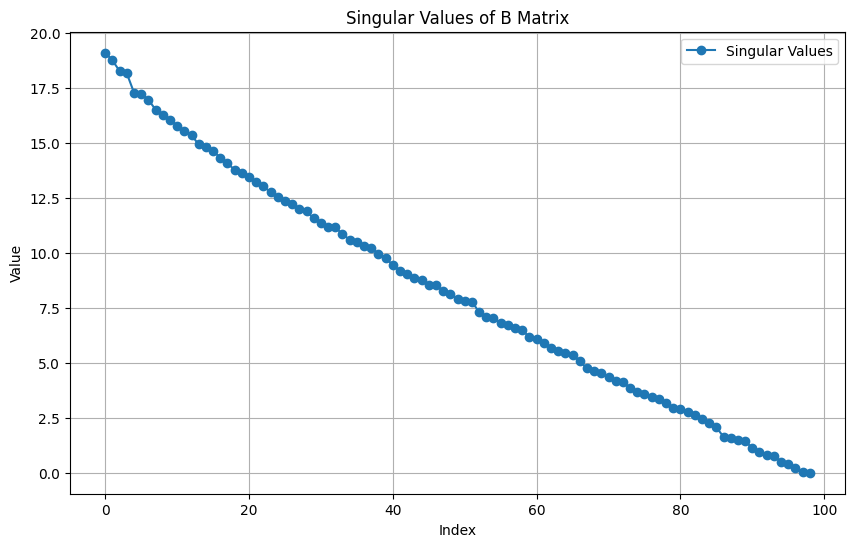

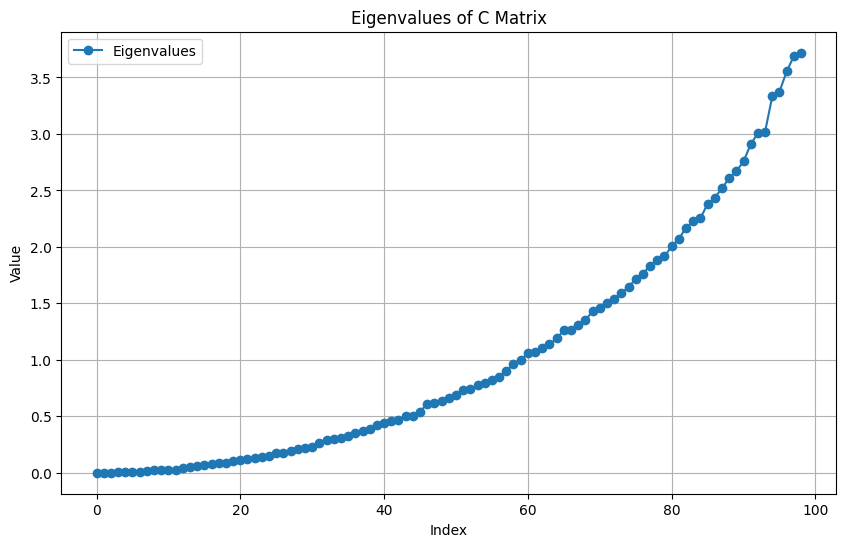

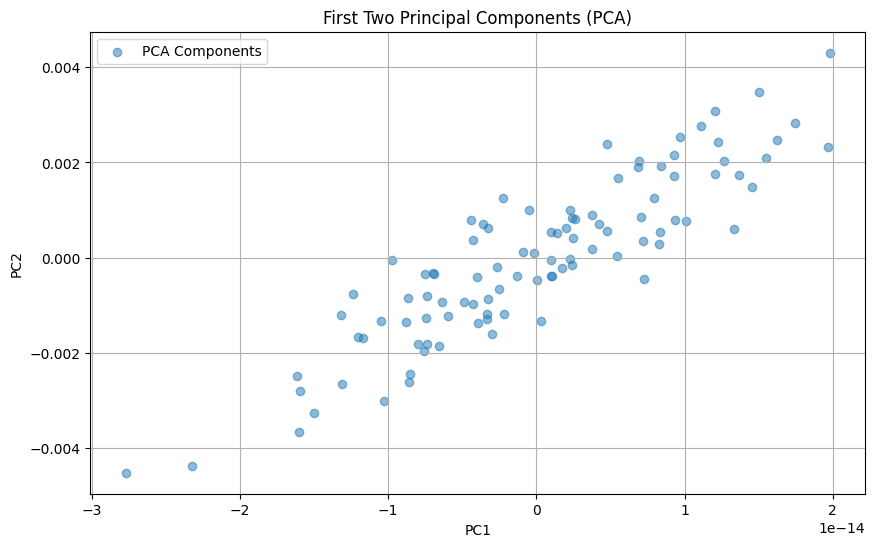

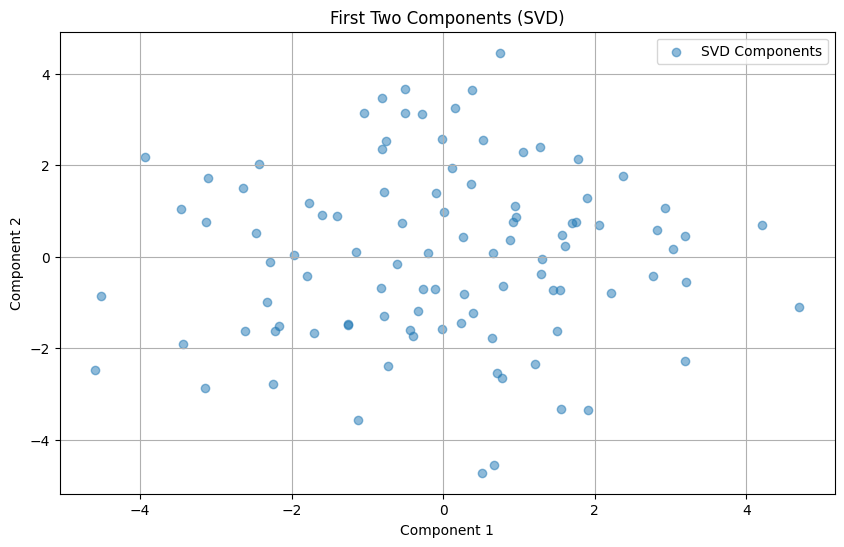

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from files
pca_results = np.loadtxt('pca_results.txt', skiprows=2)  # Skip header lines
svd_results = np.loadtxt('svd_results.txt', skiprows=2)
singular_values = np.loadtxt('singular_values.txt', skiprows=2)
eigenvalues = np.loadtxt('eigenvalues.txt', skiprows=2)

# Plot singular values
plt.figure(figsize=(10, 6))
plt.plot(singular_values, marker='o', label='Singular Values')
plt.title('Singular Values of B Matrix')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Plot eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, marker='o', label='Eigenvalues')
plt.title('Eigenvalues of C Matrix')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Visualize PCA results (first two principal components)
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, label='PCA Components')
plt.title('First Two Principal Components (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid()
plt.show()

# Visualize SVD results (first two components)
plt.figure(figsize=(10, 6))
plt.scatter(svd_results[:, 0], svd_results[:, 1], alpha=0.5, label='SVD Components')
plt.title('First Two Components (SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid()
plt.show()

## QR Decomposition of the matrix

In [8]:
%%writefile svd_parallel.cpp
#include <iostream>
#include <fstream>
#include <Eigen/Dense>
#include <random>
#include <chrono>
#include <cuda_runtime.h>

using namespace std;
using namespace Eigen;

// CUDA kernel for matrix multiplication
__global__ void matrix_multiply_kernel(const double* A, const double* B, double* C, int n, int m, int p) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < n && col < p) {
        double sum = 0.0;
        for (int k = 0; k < m; ++k) {
            sum += A[row * m + k] * B[k * p + col];
        }
        C[row * p + col] = sum;
    }
}

// Function to perform matrix multiplication on GPU
void cuda_matrix_multiply(const MatrixXd& A, const MatrixXd& B, MatrixXd& C) {
    int n = A.rows();
    int m = A.cols();
    int p = B.cols();

    // Allocate memory on the device
    double* d_A, *d_B, *d_C;
    cudaMalloc(&d_A, n * m * sizeof(double));
    cudaMalloc(&d_B, m * p * sizeof(double));
    cudaMalloc(&d_C, n * p * sizeof(double));

    // Copy data to the device
    cudaMemcpy(d_A, A.data(), n * m * sizeof(double), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, B.data(), m * p * sizeof(double), cudaMemcpyHostToDevice);

    // Define block and grid dimensions
    dim3 block(16, 16);
    dim3 grid((p + block.x - 1) / block.x, (n + block.y - 1) / block.y);

    // Launch the kernel
    matrix_multiply_kernel<<<grid, block>>>(d_A, d_B, d_C, n, m, p);

    // Copy result back to host
    cudaMemcpy(C.data(), d_C, n * p * sizeof(double), cudaMemcpyDeviceToHost);

    // Free device memory
    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
}

// Main function
int main() {
    // Set random seed for reproducibility
    srand(time(0));

    // Define dimensions of the matrix
    int n = 1000; // Number of rows
    int m = 1000; // Number of columns

    // Generate random matrix X with values from a standard normal distribution
    MatrixXd X(n, m);
    random_device rd;
    mt19937 gen(rd());
    normal_distribution<double> dist(0.0, 1.0);

    auto start_time = chrono::high_resolution_clock::now(); // Start timing

    // Parallelize matrix initialization using OpenMP
    #pragma omp parallel for
    for (int i = 0; i < n; ++i) {
        for (int j = 0; j < m; ++j) {
            X(i, j) = i + j + dist(gen) * 0.001;
        }
    }

    // Compute mean across columns using OpenMP
    RowVectorXd X_mean(m);
    #pragma omp parallel for reduction(+:X_mean)
    for (int j = 0; j < m; ++j) {
        double sum = 0.0;
        for (int i = 0; i < n; ++i) {
            sum += X(i, j);
        }
        X_mean(j) = sum / n;
    }

    // Subtract mean to center the data
    MatrixXd B = X;
    #pragma omp parallel for
    for (int i = 0; i < n; ++i) {
        B.row(i) -= X_mean;
    }

    // Compute variance of the data using OpenMP
    double var = 0.0;
    #pragma omp parallel for reduction(+:var)
    for (int i = 0; i < n; ++i) {
        for (int j = 0; j < m; ++j) {
            var += B(i, j) * B(i, j);
        }
    }
    var /= (n * m);

    // Normalize the data by dividing by the square root of variance
    B /= sqrt(var);

    // Compute covariance matrix using CUDA
    MatrixXd C(n, n);
    cuda_matrix_multiply(B.transpose(), B, C);
    C /= (n - 1);

    // Perform eigen decomposition using Eigen library
    SelfAdjointEigenSolver<MatrixXd> eigen_solver(C);
    VectorXd eigenvalues = eigen_solver.eigenvalues(); // Eigenvalues
    MatrixXd eigenvectors = eigen_solver.eigenvectors(); // Eigenvectors

    // Project X onto PC space
    MatrixXd T_pca = B * eigenvectors;

    // Perform Singular Value Decomposition (SVD)
    JacobiSVD<MatrixXd> svd(B, ComputeThinU | ComputeThinV);
    MatrixXd U = svd.matrixU();
    VectorXd singular_values = svd.singularValues();
    MatrixXd Vt = svd.matrixV().transpose();

    // Construct the Sigma matrix
    MatrixXd Sigma(n, m);
    Sigma.setZero();
    for (int i = 0; i < singular_values.size(); ++i) {
        Sigma(i, i) = singular_values(i);
    }

    // Compute T_svd = U * Sigma
    MatrixXd T_svd = U * Sigma;

    auto end_time = chrono::high_resolution_clock::now(); // End timing
    chrono::duration<double> elapsed_seconds = end_time - start_time;

    // Save results to files
    ofstream pca_file("pca_results_parallel.txt");
    ofstream svd_file("svd_results_parallel.txt");
    ofstream singular_values_file("singular_values_parallel.txt");
    ofstream eigenvalues_file("eigenvalues_parallel.txt");

    if (pca_file.is_open()) {
        pca_file << "Principal components using PCA T_pca = B * V:\n";
        pca_file << T_pca << endl;
        pca_file.close();
    }

    if (svd_file.is_open()) {
        svd_file << "Principal components using SVD T_svd = U * Sigma:\n";
        svd_file << T_svd << endl;
        svd_file.close();
    }

    if (singular_values_file.is_open()) {
        singular_values_file << "Singular values of B matrix:\n";
        singular_values_file << singular_values << endl;
        singular_values_file.close();
    }

    if (eigenvalues_file.is_open()) {
        eigenvalues_file << "Eigenvalues of C matrix:\n";
        eigenvalues_file << eigenvalues << endl;
        eigenvalues_file.close();
    }

    // Print execution time
    cout << "Execution time: " << elapsed_seconds.count() << " seconds" << endl;

    return 0;
}

Overwriting svd_parallel.cpp


In [9]:
!nvcc -O3 -I/usr/include/eigen3 svd_parallel.cpp -o svd_parallel -fopenmp -lcudart

nvcc fatal   : Unknown option '-fopenmp'


In [10]:
!./svd_parallel

/usr/bin/sh: 1: ./svd_parallel: not found


In [17]:
%%writefile svd_mpi.cpp
#include <iostream>
#include <fstream>
#include <Eigen/Dense>
#include <random>
#include <chrono>
#include <mpi.h>

using namespace std;
using namespace Eigen;

// Function to compute covariance matrix in parallel using MPI
MatrixXd mpi_covariance(const MatrixXd& B, int n, int m) {
    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    // Split the rows of B among processes
    int rows_per_proc = n / size;
    int start_row = rank * rows_per_proc;
    int end_row = (rank == size - 1) ? n : start_row + rows_per_proc;

    // Local covariance computation
    MatrixXd local_BtB = MatrixXd::Zero(m, m);
    for (int i = start_row; i < end_row; ++i) {
        local_BtB += B.row(i).transpose() * B.row(i);
    }

    // Gather results at the root process
    MatrixXd global_BtB = MatrixXd::Zero(m, m);
    MPI_Reduce(local_BtB.data(), global_BtB.data(), m * m, MPI_DOUBLE, MPI_SUM, 0, MPI_COMM_WORLD);

    if (rank == 0) {
        global_BtB /= (n - 1); // Normalize by (n-1)
    }
    return global_BtB;
}

int main(int argc, char** argv) {
    // Initialize MPI
    MPI_Init(&argc, &argv);

    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    // Define dimensions of the matrix
    int n = 1000; // Number of rows
    int m = 1000; // Number of columns

    // Generate random matrix X with values from a standard normal distribution
    MatrixXd X(n, m);
    random_device rd;
    mt19937 gen(rd());
    normal_distribution<double> dist(0.0, 1.0);

    auto start_time = chrono::high_resolution_clock::now(); // Start timing

    // Only rank 0 generates the matrix
    if (rank == 0) {
        #pragma omp parallel for
        for (int i = 0; i < n; ++i) {
            for (int j = 0; j < m; ++j) {
                X(i, j) = i + j + dist(gen) * 0.001;
            }
        }
    }

    // Broadcast the matrix X to all processes
    MPI_Bcast(X.data(), n * m, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    // Compute mean across columns
    RowVectorXd X_mean(m);
    if (rank == 0) {
        X_mean = X.colwise().mean();
    }
    MPI_Bcast(X_mean.data(), m, MPI_DOUBLE, 0, MPI_COMM_WORLD);

    // Subtract mean to center the data
    MatrixXd B = X;
    #pragma omp parallel for
    for (int i = 0; i < n; ++i) {
        B.row(i) -= X_mean;
    }

    // Compute variance of the data
    double var = 0.0;
    #pragma omp parallel for reduction(+:var)
    for (int i = 0; i < n; ++i) {
        for (int j = 0; j < m; ++j) {
            var += B(i, j) * B(i, j);
        }
    }
    var /= (n * m);

    // Normalize the data by dividing by the square root of variance
    B /= sqrt(var);

    // Compute covariance matrix using MPI
    MatrixXd C = mpi_covariance(B, n, m);

    // Perform eigen decomposition (only on rank 0)
    VectorXd eigenvalues;
    MatrixXd eigenvectors;
    if (rank == 0) {
        SelfAdjointEigenSolver<MatrixXd> eigen_solver(C);
        eigenvalues = eigen_solver.eigenvalues(); // Eigenvalues
        eigenvectors = eigen_solver.eigenvectors(); // Eigenvectors
    }

    // Project X onto PC space (only on rank 0)
    MatrixXd T_pca;
    if (rank == 0) {
        T_pca = B * eigenvectors;
    }

    // Perform Singular Value Decomposition (SVD) (only on rank 0)
    JacobiSVD<MatrixXd> svd(B, ComputeThinU | ComputeThinV);
    MatrixXd U = svd.matrixU();
    VectorXd singular_values = svd.singularValues();
    MatrixXd Vt = svd.matrixV().transpose();

    // Construct the Sigma matrix (only on rank 0)
    MatrixXd Sigma(n, m);
    if (rank == 0) {
        Sigma.setZero();
        for (int i = 0; i < singular_values.size(); ++i) {
            Sigma(i, i) = singular_values(i);
        }
    }

    // Compute T_svd = U * Sigma (only on rank 0)
    MatrixXd T_svd;
    if (rank == 0) {
        T_svd = U * Sigma;
    }

    auto end_time = chrono::high_resolution_clock::now(); // End timing
    chrono::duration<double> elapsed_seconds = end_time - start_time;

    // Save results to files (only on rank 0)
    if (rank == 0) {
        ofstream pca_file("pca_results.txt");
        ofstream svd_file("svd_results.txt");
        ofstream singular_values_file("singular_values.txt");
        ofstream eigenvalues_file("eigenvalues.txt");

        if (pca_file.is_open()) {
            pca_file << "Principal components using PCA T_pca = B * V:\n";
            pca_file << T_pca << endl;
            pca_file.close();
        }

        if (svd_file.is_open()) {
            svd_file << "Principal components using SVD T_svd = U * Sigma:\n";
            svd_file << T_svd << endl;
            svd_file.close();
        }

        if (singular_values_file.is_open()) {
            singular_values_file << "Singular values of B matrix:\n";
            singular_values_file << singular_values << endl;
            singular_values_file.close();
        }

        if (eigenvalues_file.is_open()) {
            eigenvalues_file << "Eigenvalues of C matrix:\n";
            eigenvalues_file << eigenvalues << endl;
            eigenvalues_file.close();
        }

        // Print execution time
        cout << "Execution time: " << elapsed_seconds.count() << " seconds" << endl;
    }

    // Finalize MPI
    MPI_Finalize();
    return 0;
}

Writing svd_mpi.cpp


In [15]:
!apt install openmpi-bin libopenmpi-dev -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  autoconf automake autotools-dev flang-18 ibverbs-providers libasan6
  libcaf-openmpi-3 libclang-cpp18 libcoarrays-dev libcoarrays-openmpi-dev
  libevent-core-2.1-7 libevent-dev libevent-extra-2.1-7 libevent-openssl-2.1-7
  libevent-pthreads-2.1-7 libfabric1 libflang-18-dev libgcc-10-dev
  libhwloc-dev libhwloc-plugins libhwloc15 libibverbs-dev libibverbs1
  libllvm18 libltdl-dev libnl-3-200 libnl-3-dev libnl-route-3-200
  libnl-route-3-dev libnuma-dev libopenmpi3 libpmix2 libpsm-infinipath1
  libpsm2-2 librdmacm1 libsigsegv2 libstdc++-10-dev libtool libxnvctrl0 m4
  openmpi-common
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext libhwloc-contrib-plugins
  libtool-doc openmpi-doc libstdc++-10-doc gfortran | fortran95-compiler
  gcj-jdk m4-doc
The following NEW packages will be installed:
  autoconf automake autoto

In [18]:
!mpic++ -O3 -I/usr/include/eigen3 svd_mpi.cpp -o svd_mpi

In [22]:
!mpirun --allow-run-as-root -np 1 ./svd_mpi 
!mpirun --allow-run-as-root -np 2 ./svd_mpi 
!mpirun --allow-run-as-root -np 4 ./svd_mpi 
!mpirun --allow-run-as-root -np 8 ./svd_mpi 
!mpirun --allow-run-as-root -np 16 ./svd_mpi 
!mpirun --allow-run-as-root -np 32 ./svd_mpi 
!mpirun --allow-run-as-root -np 64 ./svd_mpi 

Execution time: 18.2884 seconds
Execution time: 21.8516 seconds
Execution time: 17.7715 seconds
Execution time: 17.6233 seconds
Execution time: 18 seconds
Execution time: 33.0913 seconds
--------------------------------------------------------------------------
There are not enough slots available in the system to satisfy the 64
slots that were requested by the application:

  ./svd_mpi

Either request fewer slots for your application, or make more slots
available for use.

A "slot" is the Open MPI term for an allocatable unit where we can
launch a process.  The number of slots available are defined by the
environment in which Open MPI processes are run:

  1. Hostfile, via "slots=N" clauses (N defaults to number of
     processor cores if not provided)
  2. The --host command line parameter, via a ":N" suffix on the
     hostname (N defaults to 1 if not provided)
  3. Resource manager (e.g., SLURM, PBS/Torque, LSF, etc.)
  4. If none of a hostfile, the --host command line parameter, o

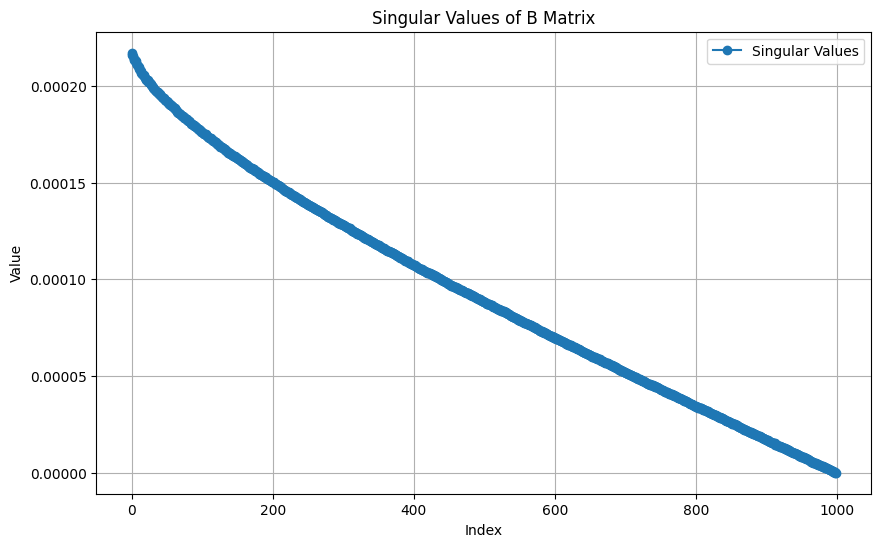

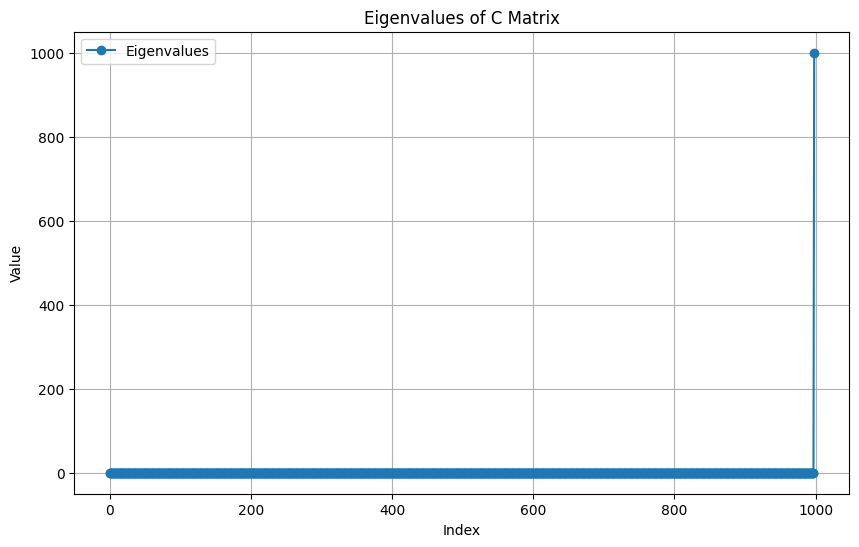

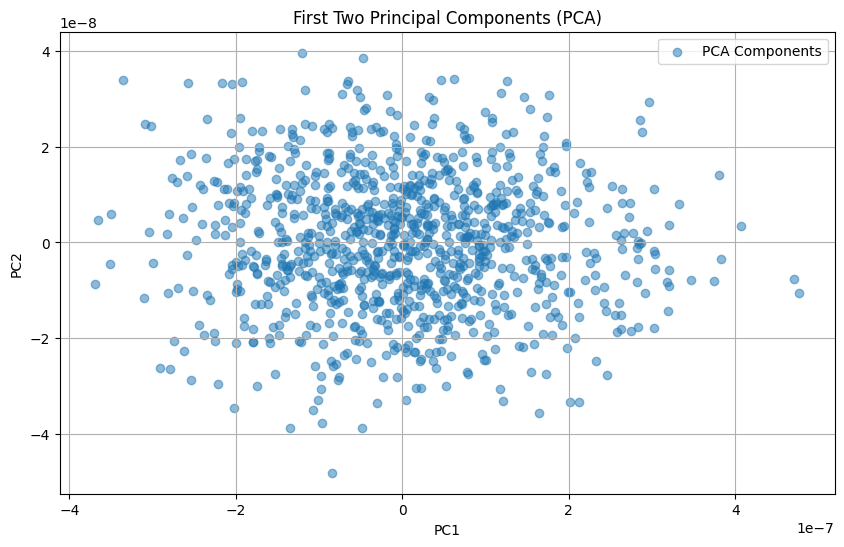

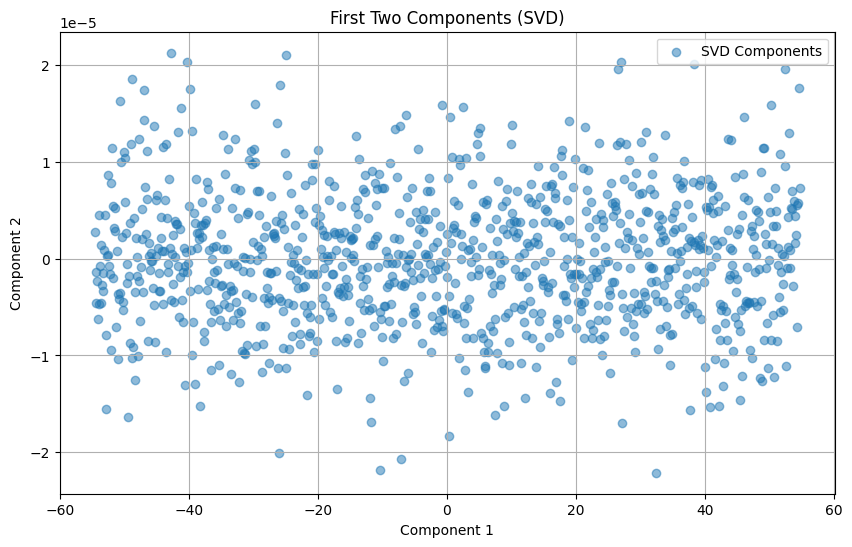

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from files
pca_results = np.loadtxt('pca_results.txt', skiprows=2)  # Skip header lines
svd_results = np.loadtxt('svd_results.txt', skiprows=2)
singular_values = np.loadtxt('singular_values.txt', skiprows=2)
eigenvalues = np.loadtxt('eigenvalues.txt', skiprows=2)

# Plot singular values
plt.figure(figsize=(10, 6))
plt.plot(singular_values, marker='o', label='Singular Values')
plt.title('Singular Values of B Matrix')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Plot eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, marker='o', label='Eigenvalues')
plt.title('Eigenvalues of C Matrix')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

# Visualize PCA results (first two principal components)
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], alpha=0.5, label='PCA Components')
plt.title('First Two Principal Components (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid()
plt.show()

# Visualize SVD results (first two components)
plt.figure(figsize=(10, 6))
plt.scatter(svd_results[:, 0], svd_results[:, 1], alpha=0.5, label='SVD Components')
plt.title('First Two Components (SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid()
plt.show()